# Inference Pipeline with Scikit-learn and Linear Learner
Typically a Machine Learning (ML) process consists of few steps: data gathering with various ETL jobs, pre-processing the data, featurizing the dataset by incorporating standard techniques or prior knowledge, and finally training an ML model using an algorithm. 
In many cases, when the trained model is used for processing real time or batch prediction requests, the model receives data in a format which needs to pre-processed (e.g. featurized) before it can be passed to the algorithm. In the following notebook, we will demonstrate how you can build your ML Pipeline leveraging the Sagemaker Scikit-learn container and SageMaker Linear Learner algorithm & after the model is trained, deploy the Pipeline (Data preprocessing and Lineara Learner) as an Inference Pipeline behind a single Endpoint for real time inference and for batch inferences using Amazon SageMaker Batch Transform.

We will demonstrate this using the Abalone Dataset to guess the age of Abalone with physical features. The dataset is available from [UCI Machine Learning](https://archive.ics.uci.edu/ml/datasets/abalone); the aim for this task is to determine age of an Abalone (a kind of shellfish) from its physical measurements. We'll use Sagemaker's Scikit-learn container to featurize the dataset so that it can be used for training with Linear Learner.

### Table of contents
* [Preprocessing data and training the model](#training)
 * [Upload the data for training](#upload_data)
 * [Create a Scikit-learn script to train with](#create_sklearn_script)
 * [Create SageMaker Scikit Estimator](#create_sklearn_estimator)
 * [Batch transform our training data](#preprocess_train_data)
 * [Fit a LinearLearner Model with the preprocessed data](#training_model)
* [Inference Pipeline with Scikit preprocessor and Linear Learner](#inference_pipeline)
 * [Set up the inference pipeline](#pipeline_setup)
 * [Make a request to our pipeline endpoint](#pipeline_inference_request)
 * [Delete Endpoint](#delete_endpoint)

Let's first create our Sagemaker session and role, and create a S3 prefix to use for the notebook example.

In [125]:
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   
import io
import time
import json
import sagemaker.amazon.common as smac
%matplotlib inline

In [126]:
# S3 prefix
bucket_name = 'demo-saeed'
prefix = 'fraudcredit-pipeline'

import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

# Preprocessing data and training the model <a class="anchor" id="training"></a>


In [127]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/raw'.format(bucket_name, prefix))
s3_input_train.config

{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated',
   'S3DataType': 'S3Prefix',
   'S3Uri': 's3://demo-saeed/fraudcredit-pipeline/raw'}}}

## Create a Scikit-learn script to train with <a class="anchor" id="create_sklearn_script"></a>
To run Scikit-learn on Sagemaker `SKLearn` Estimator with a script as an entry point. The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables, such as:

* SM_MODEL_DIR: A string representing the path to the directory to write model artifacts to. These artifacts are uploaded to S3 for model hosting.
* SM_OUTPUT_DIR: A string representing the filesystem path to write output artifacts to. Output artifacts may include checkpoints, graphs, and other files to save, not including model artifacts. These artifacts are compressed and uploaded to S3 to the same S3 prefix as the model artifacts.

Supposing two input channels, 'train' and 'test', were used in the call to the Chainer estimator's fit() method, the following will be set, following the format SM_CHANNEL_[channel_name]:

* SM_CHANNEL_TRAIN: A string representing the path to the directory containing data in the 'train' channel
* SM_CHANNEL_TEST: Same as above, but for the 'test' channel.

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an argparse.ArgumentParser instance. For example, the script run by this notebook:

```python
from __future__ import print_function

import time
import sys
from io import StringIO
import os
import shutil

import argparse
import csv
import json
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.externals import joblib
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer, StandardScaler, OneHotEncoder

from sagemaker_containers.beta.framework import (
    content_types, encoders, env, modules, transformer, worker)

# Since we get a headerless CSV file we specify the column names here.
feature_columns_names = [
    'sex', # M, F, and I (infant)
    'length', # Longest shell measurement
    'diameter', # perpendicular to length
    'height', # with meat in shell
    'whole_weight', # whole abalone
    'shucked_weight', # weight of meat
    'viscera_weight', # gut weight (after bleeding)
    'shell_weight'] # after being dried

label_column = 'rings'

feature_columns_dtype = {
    'sex': str,
    'length': np.float64,
    'diameter': np.float64,
    'height': np.float64,
    'whole_weight': np.float64,
    'shucked_weight': np.float64,
    'viscera_weight': np.float64,
    'shell_weight': np.float64}

label_column_dtype = {'rings': np.float64} # +1.5 gives the age in years

def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

if __name__ == '__main__':

    parser = argparse.ArgumentParser()

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])

    args = parser.parse_args()

    # Take the set of files and read them all into a single pandas dataframe
    input_files = [ os.path.join(args.train, file) for file in os.listdir(args.train) ]
    if len(input_files) == 0:
        raise ValueError(('There are no files in {}.\n' +
                          'This usually indicates that the channel ({}) was incorrectly specified,\n' +
                          'the data specification in S3 was incorrectly specified or the role specified\n' +
                          'does not have permission to access the data.').format(args.train, "train"))
    
    raw_data = [ pd.read_csv(
        file, 
        header=None, 
        names=feature_columns_names + [label_column],
        dtype=merge_two_dicts(feature_columns_dtype, label_column_dtype)) for file in input_files ]
    concat_data = pd.concat(raw_data)
    
    # This section is adapted from the scikit-learn example of using preprocessing pipelines:
    #
    # https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
    #
    # We will train our classifier with the following features:
    # Numeric Features:
    # - length:  Longest shell measurement
    # - diameter: Diameter perpendicular to length
    # - height:  Height with meat in shell
    # - whole_weight: Weight of whole abalone
    # - shucked_weight: Weight of meat
    # - viscera_weight: Gut weight (after bleeding)
    # - shell_weight: Weight after being dried
    # Categorical Features:
    # - sex: categories encoded as strings {'M', 'F', 'I'} where 'I' is Infant
    numeric_features = list(feature_columns_names)
    numeric_features.remove('sex')
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_features = ['sex']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)],
        remainder="drop")
    
    preprocessor.fit(concat_data)

    joblib.dump(preprocessor, os.path.join(args.model_dir, "model.joblib"))

    print("saved model!")
    
    
def input_fn(input_data, content_type):
    """Parse input data payload
    
    We currently only take csv input. Since we need to process both labelled
    and unlabelled data we first determine whether the label column is present
    by looking at how many columns were provided.
    """
    if content_type == 'text/csv':
        # Read the raw input data as CSV.
        df = pd.read_csv(StringIO(input_data), 
                         header=None)
        
        if len(df.columns) == len(feature_columns_names) + 1:
            # This is a labelled example, includes the ring label
            df.columns = feature_columns_names + [label_column]
        elif len(df.columns) == len(feature_columns_names):
            # This is an unlabelled example.
            df.columns = feature_columns_names
            
        return df
    else:
        raise ValueError("{} not supported by script!".format(content_type))
        

def output_fn(prediction, accept):
    """Format prediction output
    
    The default accept/content-type between containers for serial inference is JSON.
    We also want to set the ContentType or mimetype as the same value as accept so the next
    container can read the response payload correctly.
    """
    if accept == "application/json":
        instances = []
        for row in prediction.tolist():
            instances.append({"features": row})

        json_output = {"instances": instances}

        return worker.Response(json.dumps(json_output), accept, mimetype=accept)
    elif accept == 'text/csv':
        return worker.Response(encoders.encode(prediction, accept), accept, mimetype=accept)
    else:
        raise RuntimeException("{} accept type is not supported by this script.".format(accept))


def predict_fn(input_data, model):
    """Preprocess input data
    
    We implement this because the default predict_fn uses .predict(), but our model is a preprocessor
    so we want to use .transform().

    The output is returned in the following order:
    
        rest of features either one hot encoded or standardized
    """
    features = model.transform(input_data)
    
    if label_column in input_data:
        # Return the label (as the first column) and the set of features.
        return np.insert(features, 0, input_data[label_column], axis=1)
    else:
        # Return only the set of features
        return features
    

def model_fn(model_dir):
    """Deserialize fitted model
    """
    preprocessor = joblib.load(os.path.join(model_dir, "model.joblib"))
    return preprocessor
```

## Create SageMaker Scikit Estimator <a class="anchor" id="create_sklearn_estimator"></a>

To run our Scikit-learn training script on SageMaker, we construct a `sagemaker.sklearn.estimator.sklearn` estimator, which accepts several constructor arguments:

* __entry_point__: The path to the Python script SageMaker runs for training and prediction.
* __role__: Role ARN
* __train_instance_type__ *(optional)*: The type of SageMaker instances for training. __Note__: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* __sagemaker_session__ *(optional)*: The session used to train on Sagemaker.

To see the code for the SKLearn Estimator, see here: https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/sklearn

In [199]:
from sagemaker.sklearn.estimator import SKLearn

script_path = 'sklearn_fd_featurizer.py'

sklearn_preprocessor = SKLearn(
    entry_point=script_path,
    role=role,
    train_instance_type="ml.c4.xlarge",
    output_path='s3://{}/{}/output/'.format(bucket_name, prefix),
    #code_location='s3://<path-to-code_location>', read locally from notebook
    sagemaker_session=sagemaker_session)




In [200]:
sklearn_preprocessor.fit({'train': s3_input_train})

2019-05-29 04:00:14 Starting - Starting the training job...
2019-05-29 04:00:30 Starting - Launching requested ML instances......
2019-05-29 04:01:39 Starting - Preparing the instances for training......
2019-05-29 04:02:37 Downloading - Downloading input data
2019-05-29 04:02:37 Training - Downloading the training image...
2019-05-29 04:03:15 Uploading - Uploading generated training model
2019-05-29 04:03:03,538 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2019-05-29 04:03:03,540 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-05-29 04:03:03,551 sagemaker_sklearn_container.training INFO     Invoking user training script.
2019-05-29 04:03:03,850 sagemaker-containers INFO     Module sklearn_fd_featurizer does not provide a setup.py. 
Generating setup.py
2019-05-29 04:03:03,850 sagemaker-containers INFO     Generating setup.cfg
2019-05-29 04:03:03,851 sagemaker-containers INFO     Generating MANIFEST.in
2019-05-29

In [201]:
sklearn_preprocessor.model_data

's3://demo-saeed/fraudcredit-pipeline/output/sagemaker-scikit-learn-2019-05-29-04-00-14-321/output/model.tar.gz'

In [202]:
sklearn_preprocessor.uploaded_code

UserCode(s3_prefix='s3://demo-saeed/sagemaker-scikit-learn-2019-05-29-04-00-14-321/source/sourcedir.tar.gz', script_name='sklearn_fd_featurizer.py')

## Batch transform our training data <a class="anchor" id="preprocess_train_data"></a>
Now that our proprocessor is properly fitted, let's go ahead and preprocess our training data. Let's use batch transform to directly preprocess the raw data and store right back into s3.

In [22]:
# Define a SKLearn Transformer from the trained SKLearn Estimator
transformer = sklearn_preprocessor.transformer(
    instance_count=1, 
    instance_type='ml.m4.xlarge',
    assemble_with = 'Line',
    output_path = 's3://{}/{}/transformer_output/'.format(bucket_name, prefix),
    accept = 'text/csv')

Using already existing model: sagemaker-scikit-learn-2019-05-28-17-12-26-130


In [23]:
s3_input_train.config['DataSource']['S3DataSource']['S3Uri']

's3://demo-saeed/fraudcredit-pipeline/raw'

In [24]:
transformer.output_path

's3://demo-saeed/fraudcredit-pipeline/transformer_output/'

In [25]:
# Preprocess training input
transformer.transform(s3_input_train.config['DataSource']['S3DataSource']['S3Uri'], content_type='text/csv', split_type='Line')
print('Waiting for transform job: ' + transformer.latest_transform_job.job_name)
transformer.wait()
preprocessed_train = transformer.output_path
preprocessed_train

Waiting for transform job: sagemaker-scikit-learn-2019-05-28-17-20-29-518
...............................................!


's3://demo-saeed/fraudcredit-pipeline/transformer_output/'

## Fit a LinearLearner Model with the preprocessed data <a class="anchor" id="training_model"></a>
Let's take the preprocessed training data and fit a LinearLearner Model. Sagemaker provides prebuilt algorithm containers that can be used with the Python SDK. The previous Scikit-learn job preprocessed the raw Titanic dataset into labeled, useable data that we can now use to fit a binary classifier Linear Learner model.

For more on Linear Learner see: https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html

In [28]:
import pandas as pd
data_location = 's3://demo-saeed/fraudcredit-pipeline/transformer_output/creditcard.csv.out'

data = pd.read_csv(data_location, header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,0.0,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,0.0,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,0.0,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,0.0,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


In [29]:
X = data.iloc[:, 1:]
y = data.loc[:, 0]

In [30]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = 0.2 ,random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions Validation dataset: ", len(X_val))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_val)+len(X_test))




Number transactions train dataset:  182261
Number transactions Validation dataset:  45566
Number transactions test dataset:  56957
Total number of transactions:  284784


### Upload training set

In [35]:
f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, X_train.values.astype('float32'), y_train.values.reshape(-1).astype('float32'))
f.seek(0)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'model_train','linear_train.data')).upload_fileobj(f)
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/model_train'.format(bucket_name, prefix))
s3_input_train.config

{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated',
   'S3DataType': 'S3Prefix',
   'S3Uri': 's3://demo-saeed/fraudcredit-pipeline/model_train'}}}

### Upload validation set

In [36]:
f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, X_val.values.astype('float32'), y_val.values.reshape(-1).astype('float32'))
f.seek(0)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'model_validation','linear_val.data')).upload_fileobj(f)
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/model_validation'.format(bucket_name, prefix))
s3_input_validation.config


{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated',
   'S3DataType': 'S3Prefix',
   'S3Uri': 's3://demo-saeed/fraudcredit-pipeline/model_validation'}}}

### Upload test set


In [37]:
test_file = 'linear_test.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, X_test.values.astype('float32'), y_test.values.reshape(-1).astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'model_test',test_file)).upload_fileobj(f)
s3_input_test = sagemaker.s3_input(s3_data='s3://{}/{}/model_test'.format(bucket_name, prefix))
s3_input_test.config

{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated',
   'S3DataType': 'S3Prefix',
   'S3Uri': 's3://demo-saeed/fraudcredit-pipeline/model_test'}}}

# training

In [38]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')
container

'382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'

In [39]:
output_location = 's3://{}/{}/model_output'.format(bucket_name, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://demo-saeed/fraudcredit-pipeline/model_output


In [40]:
X_train.shape

(182261, 30)

In [ ]:
import boto3
import sagemaker

sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.m4.2xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=30,
                           predictor_type='binary_classifier',
                           epochs = 1,
                           mini_batch_size=200)

linear.fit({'train': s3_input_train,  'validation': s3_input_validation, 'test': s3_input_test})

# train_max_run = 3600,

2019-05-28 17:32:20 Starting - Starting the training job...
2019-05-28 17:32:21 Starting - Launching requested ML instances.........
2019-05-28 17:33:55 Starting - Preparing the instances for training...
2019-05-28 17:34:34 Downloading - Downloading input data.

In [44]:
linear.output_path

's3://demo-saeed/fraudcredit-pipeline/model_output'

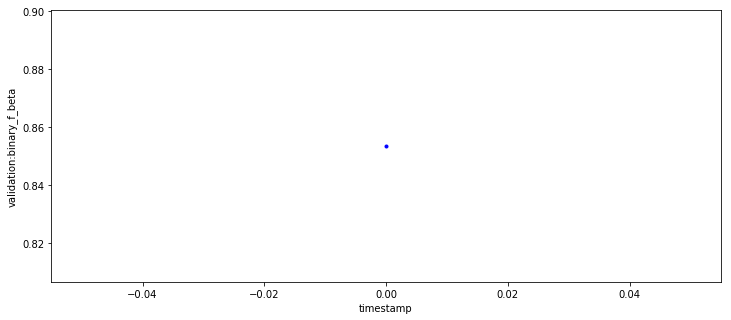

In [45]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

training_job_name = linear._current_job_name
metric_name = 'validation:binary_f_beta'

metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name]).dataframe()
plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b.', legend=False)
plt.set_ylabel(metric_name);

In [132]:
#linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.c5.xlarge', endpoint_name='pip-model-aws-linear-learner', update_endpoint=True)


ClientError: An error occurred (ValidationException) when calling the CreateEndpoint operation: Cannot create already existing endpoint "arn:aws:sagemaker:us-east-1:079329190341:endpoint/pip-model-aws-linear-learner".

In [61]:
linear_predictor.content_type

'text/csv'

In [62]:
linear_predictor.endpoint

'pip-model-aws-linear-learner'

In [66]:
X_test.columns =['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [69]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer
#linear_predictor.predict(X_test.iloc[0])

linear_predictor.predict(X_test.loc[83053])


{'predictions': [{'score': 0.0032706407364457846, 'predicted_label': 0.0}]}

# Serial Inference Pipeline with Scikit preprocessor and Linear Learner <a class="anchor" id="serial_inference"></a>


## Set up the inference pipeline <a class="anchor" id="pipeline_setup"></a>
Setting up a Machine Learning pipeline can be done with the Pipeline Model. This sets up a list of models in a single endpoint; in this example, we configure our pipeline model with the fitted Scikit-learn inference model and the fitted Linear Learner model. Deploying the model follows the same ```deploy``` pattern in the SDK.

In [203]:
from sagemaker.model import Model
from sagemaker.pipeline import PipelineModel
import boto3
from time import gmtime, strftime

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

scikit_learn_inferencee_model = sklearn_preprocessor.create_model()
linear_learner_model = linear.create_model()

model_name = 'inference-pipeline-' + timestamp_prefix
endpoint_name = 'inference-pipeline-ep-' + timestamp_prefix
sm_model = PipelineModel(
    name=model_name, 
    role=role, 
    models=[
        scikit_learn_inferencee_model, 
        linear_learner_model])

sm_model.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge', endpoint_name=endpoint_name)

-----------------------------------------------------------------------------------------------------!

In [204]:
sm_model.endpoint_name

'inference-pipeline-ep-2019-05-29-04-08-33'

## Make a request to our pipeline endpoint <a class="anchor" id="pipeline_inference_request"></a>

Here we just grab the first line from the test data (you'll notice that the inference python script is very particular about the ordering of the inference request data). The ```ContentType``` field configures the first container, while the ```Accept``` field configures the last container. You can also specify each container's ```Accept``` and ```ContentType``` values using environment variables.

We make our request with the payload in ```'text/csv'``` format, since that is what our script currently supports. If other formats need to be supported, this would have to be added to the ```output_fn()``` method in our entry point. Note that we set the ```Accept``` to ```application/json```, since Linear Learner does not support ```text/csv``` ```Accept```. The prediction output in this case is trying to guess the number of rings the abalone specimen would have given its other physical features; the actual number of rings is 10.

In [209]:
input_Data = ",".join( map( str, X_test.iloc[0] ) )
input_Data 

'-0.24786986316588436,0.6219285089696768,-0.40766669389149396,-0.3509218261955573,-0.8233977719261477,0.19649077448261495,0.7957025664635167,-0.3106965608154121,0.1893144439369641,-1.3452420342811608,0.6716650083446972,1.3077588367812916,0.8142580498465056,1.0119520742476555,0.2651733617318809,0.3013157742844578,-1.0654016616682236,-0.4894835126703879,1.1260764727702786,-0.20233190321945185,-0.11313468325002365,-1.0829134003296332,-3.1805931958920532,0.6657326387824644,5.848977361387145,-0.21185041492735887,0.6963500086716471,-0.2664339150607643,0.15947289316968447,0.06984808807569087'

In [210]:
from sagemaker.predictor import json_serializer, csv_serializer, json_deserializer, RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON
payload = input_Data
actual_rings = 10
predictor = RealTimePredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=csv_serializer,
    content_type=CONTENT_TYPE_CSV,
    accept=CONTENT_TYPE_JSON)

print(predictor.predict(payload))


b'{"predictions": [{"score": 0.0022159225773066282, "predicted_label": 0.0}]}'


## Delete Endpoint <a class="anchor" id="delete_endpoint"></a>
Once we are finished with the endpoint, we clean up the resources!

In [ ]:
# sm_client = sagemaker_session.boto_session.client('sagemaker')
# sm_client.delete_endpoint(EndpointName=endpoint_name)